### Imports 

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import spacy
import re
from pprint import pprint

import nltk
nltk.download('vader_lexicon')
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords

from collections import Counter
from wordcloud import WordCloud


import warnings 
warnings.filterwarnings("ignore", category=DeprecationWarning)

%matplotlib inline

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Dodlaraj\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
# pip install spacy


In [3]:
df = pd.read_pickle('./pre-processed.pkl')

In [4]:
df.shape

(98727, 44)

In [5]:
df = df.drop(['tidy_tweet','tidy_tweet_tokens','no_stop_joined','Hashtag','Location'], axis=1)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98727 entries, 0 to 98726
Data columns (total 39 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   created_at                 98727 non-null  object 
 1   id                         98727 non-null  int64  
 2   id_str                     98727 non-null  int64  
 3   text                       98727 non-null  object 
 4   truncated                  98727 non-null  bool   
 5   entities                   98727 non-null  object 
 6   metadata                   98727 non-null  object 
 7   source                     98727 non-null  object 
 8   in_reply_to_status_id      11204 non-null  float64
 9   in_reply_to_status_id_str  11204 non-null  float64
 10  in_reply_to_user_id        12568 non-null  float64
 11  in_reply_to_user_id_str    12568 non-null  float64
 12  in_reply_to_screen_name    12568 non-null  object 
 13  user                       98727 non-null  obj

In [7]:
df.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,extended_entities,withheld_scope,withheld_in_countries,device,text_tokenized,emoji_count,word_count,character_count,emoji_percent,tokens_no_stop
0,Mon Dec 05 14:14:43 +0000 2022,1599769240004972544,1599769240004972544,RT @iot_automotive: 24h round-up. A collection...,False,"{'hashtags': [{'text': 'AI', 'indices': [95, 9...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,NaN,NaN,NaN,non-standard,"[RT, @, iot_automotive, :, 24h, round-up, ., A...",0,15,140,0.0,"[round, collection, tweets, enjoy]"
1,Mon Dec 05 14:00:55 +0000 2022,1599765764113940483,1599765764113940483,Meet Powderworld: A Lightweight Simulation Env...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,...,NaN,NaN,NaN,non-standard,"[Meet, Powderworld, :, A, Lightweight, Simulat...",0,12,140,0.0,"[meet, powderworld, lightweight, simulation, e..."
2,Mon Dec 05 14:00:04 +0000 2022,1599765552154775557,1599765552154775557,RT @GothamVirtual: #vr #vrgotham #3dvideomotio...,False,"{'hashtags': [{'text': 'vr', 'indices': [19, 2...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,non-standard,"[RT, @, GothamVirtual, :, #, vr, #, vrgotham, ...",0,18,140,0.0,"[gotham, research, paper, investigates, fixed,..."
3,Mon Dec 05 14:00:04 +0000 2022,1599765551378845697,1599765551378845697,RT @lidarnews: This research paper investigate...,False,"{'hashtags': [{'text': 'lidar', 'indices': [74...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,non-standard,"[RT, @, lidarnews, :, This, research, paper, i...",0,17,140,0.0,"[research, paper, investigates, fixed, roadsid..."
4,Mon Dec 05 14:00:04 +0000 2022,1599765550544130048,1599765550544130048,RT @guidaautonoma: American drivers are more l...,False,"{'hashtags': [{'text': 'autonomous', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,NaN,NaN,NaN,non-standard,"[RT, @, guidaautonoma, :, American, drivers, a...",0,22,140,0.0,"[american, drivers, likely, benefit, self, dri..."


### Pre-Processing

#### Remove Links

In [8]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"http\S+", "", tweet)
    return tweet_no_link

In [9]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['text'])

In [10]:
def remove_links(tweet):
    tweet_no_link = re.sub(r"twitter.com\S+", "", tweet)
    return tweet_no_link

In [11]:
df['tweet_text_p'] = np.vectorize(remove_links)(df['tweet_text_p'])

### Remove twitter handles

In [12]:
def remove_users(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [13]:
df['tweet_text_p'] = np.vectorize(remove_users)(df['tweet_text_p'], "@ [\w]*", "@[\w]*")

### Remove Hashtag

In [14]:
# We decided to keep hashtags because they add value to the sentiment.
# Example df.tweet_text[20]
def remove_hashtags(tweet, pattern1):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [15]:
df['tweet_text_p'] = np.vectorize(remove_hashtags)(df['tweet_text_p'], "#")

### remove collection of words (electric)

In [16]:
# It adds to the neutrality of the tweet as the compound score is the sum of all words sentiment score. 
# Example df.tweet_text[43]
def remove_word(tweet, pattern1, pattern2):
    r = re.findall(pattern1, tweet)
    for i in r:
        tweet = re.sub(i, "", tweet)
    r = re.findall(pattern2, tweet)
    for i in r:
        tweet = re.sub(i, '', tweet)
    return tweet

In [17]:
df['tweet_text_p'] = np.vectorize(remove_word)(df['tweet_text_p'], "electric", "Tesla")

### Remove Duplicates

In [18]:
df.drop_duplicates(subset=['tweet_text_p'], keep='first', inplace=True)

In [19]:
df = df[~df.tweet_text_p.str.contains("Retweeted")]

In [20]:
df.shape

(91311, 40)

### Applying VADER Sentiment Analyzer

In [21]:
# Create an object of Vader Sentiment Analyzer
vader_analyzer = SentimentIntensityAnalyzer()

In [22]:
negative = []
neutral = []
positive = []
compound = []

In [23]:
def sentiment_scores(df, negative, neutral, positive, compound):
    for i in df['tweet_text_p']:
        sentiment_dict = vader_analyzer.polarity_scores(i)
        negative.append(sentiment_dict['neg'])
        neutral.append(sentiment_dict['neu'])
        positive.append(sentiment_dict['pos'])
        compound.append(sentiment_dict['compound'])

In [24]:
# Function calling 
sentiment_scores(df, negative, neutral, positive, compound)

In [25]:
# Prepare columns to add the scores later
df["negative"] = negative
df["neutral"] = neutral
df["positive"] = positive
df["compound"] = compound

In [26]:
# Fill the overall sentiment with encoding:
# (-1)Negative, (0)Neutral, (1)Positive
sentiment = []
for i in df['compound']:
    if i >= 0.05 : 
        sentiment.append(1)
  
    elif i <= - 0.05 : 
        sentiment.append(-1) 
        
    else : 
        sentiment.append(0)
df['sentiment'] = sentiment

In [27]:
neg_tweets = df.sentiment.value_counts()[-1]
neu_tweets = df.sentiment.value_counts()[0]
pos_tweets = df.sentiment.value_counts()[1]

### Number of tweets by sentiment

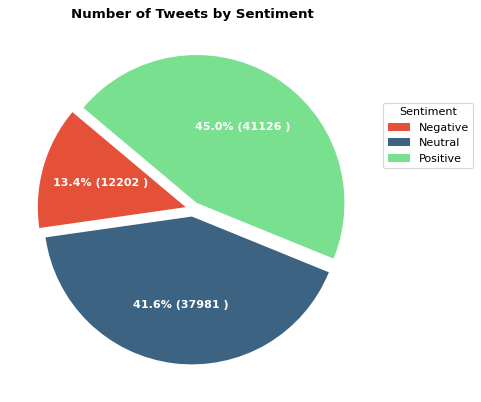

In [28]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)

wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors=['#e55039', '#3c6382', '#78e08f'],
                                  startangle=140,
                                  explode=explode)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=10, weight=700)
ax.set_title("Number of Tweets by Sentiment", fontsize=12, fontweight="bold")
plt.show()

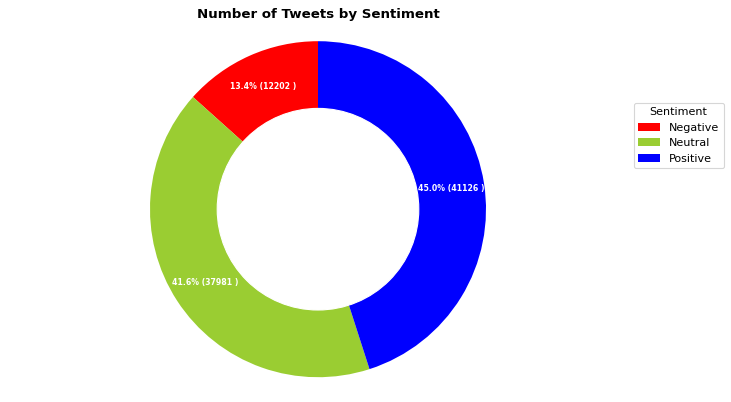

In [29]:
# Draw Plot
fig, ax = plt.subplots(figsize=(10, 6), subplot_kw=dict(aspect="equal"), dpi= 80)

data = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
categories = ['Negative', 'Neutral', 'Positive']
explode = [0.05,0.05,0.05]

def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}% ({:d} )".format(pct, absolute)
my_circle=plt.Circle( (0,0), 0.6, color='white')
wedges, texts, autotexts = ax.pie(data, 
                                  autopct=lambda pct: func(pct, data),
                                  textprops=dict(color="w"), 
                                  colors = ['red','yellowgreen','blue'],
                                  startangle=90,pctdistance=0.8, labeldistance=1.3)

# Decoration
ax.legend(wedges, categories, title="Sentiment", loc="center left", bbox_to_anchor=(1, 0.2, 0.5, 1))
plt.setp(autotexts, size=7, weight=700)
ax.set_title("Number of Tweets by Sentiment", fontsize=12, fontweight="bold")
plt.axis('equal')
p=plt.gcf()
p.gca().add_artist(my_circle)
plt.show()

### Histogram

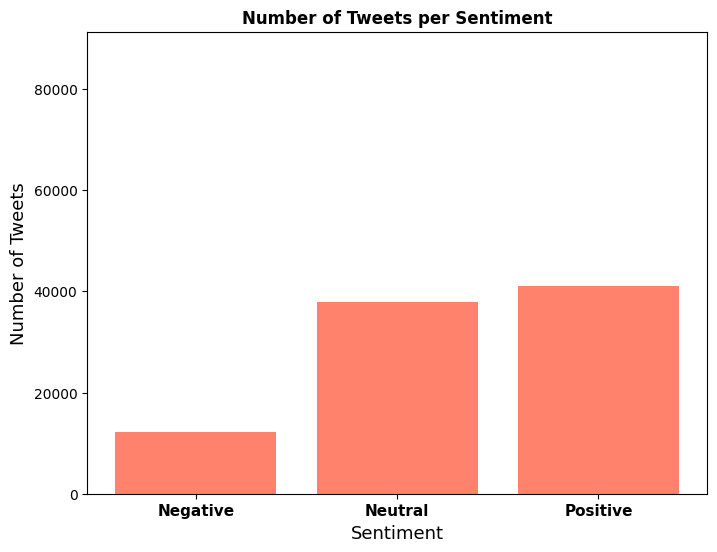

In [30]:
labels = ['Negative', 'Neutral', 'Positive']
freq = [df.sentiment.value_counts()[-1], df.sentiment.value_counts()[0], df.sentiment.value_counts()[1]]
index = np.arange(len(freq))

plt.figure(figsize=(8,6))
plt.bar(index, freq, alpha=0.8, color= 'tomato')
plt.xlabel('Sentiment', fontsize=13)
plt.ylabel('Number of Tweets', fontsize=13)
plt.xticks(index, labels, fontsize=11, fontweight="bold") 
plt.title('Number of Tweets per Sentiment', fontsize=12, fontweight="bold")
plt.ylim(0, len(df['text']))
plt.show()

### Density Plot of Overall compound score

In [31]:
# We remove the neutral compound scores to compare the negative and positive tweets
data = df[(df["sentiment"]!=0)]

C:\Users\Dodlaraj\AppData\Local\Temp\ipykernel_22304\747977632.py:3: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)


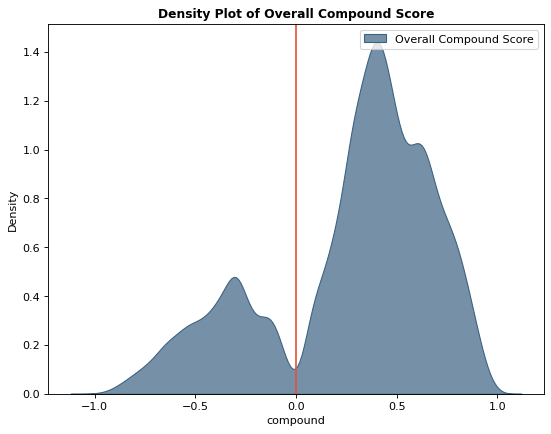

In [32]:
# Draw Plot
plt.figure(figsize=(8,6), dpi= 80)
sns.kdeplot(data["compound"], shade=True, color="#3c6382", label="Overall Compound Score", alpha=.7)

# Decoration
plt.title('Density Plot of Overall Compound Score', fontsize=11, fontweight='bold')
plt.axvline(x=0, color='#e55039')
plt.legend()
plt.show()

### Word Cloud of Positive and Negative Tweets

### Lemmatization

In [33]:
def lemmatization(tweets, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    tweets_out = []
    for sent in tweets:
        doc = nlp(" ".join(sent)) 
        tweets_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return tweets_out

In [34]:
# Initialize spacy 'en' model, keeping only tagger component (for efficiency)
# python3 -m spacy download en
nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

c:\users\dodlaraj\appdata\local\programs\python\python39\lib\site-packages\spacy\language.py:1895: UserWarning: [W123] Argument disable with value ['parser', 'ner'] is used instead of ['senter'] as specified in the config. Be aware that this might affect other components in your pipeline.
  warnings.warn(


In [35]:
# Do lemmatization keeping only noun, adj, vb, adv
df['lemmatized'] = lemmatization(df['tokens_no_stop'], allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [36]:
df.drop(['tokens_no_stop'], axis=1, inplace=True)

In [37]:
df_pos = df[df['sentiment']==1]
df_neg = df[df['sentiment']==(-1)]

In [38]:
df_pos.head()

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,word_count,character_count,emoji_percent,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Mon Dec 05 14:14:43 +0000 2022,1599769240004972544,1599769240004972544,RT @iot_automotive: 24h round-up. A collection...,False,"{'hashtags': [{'text': 'AI', 'indices': [95, 9...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,15,140,0.0,RT : 24h round-up. A collection of TOP TWEETS....,0.0,0.624,0.376,0.7206,1,"[collection, tweet, enjoy]"
2,Mon Dec 05 14:00:04 +0000 2022,1599765552154775557,1599765552154775557,RT @GothamVirtual: #vr #vrgotham #3dvideomotio...,False,"{'hashtags': [{'text': 'vr', 'indices': [19, 2...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,18,140,0.0,RT : vr vrgotham 3dvideomotion This research p...,0.0,0.847,0.153,0.4404,1,"[research, paper, investigate, fix, roadside, ..."
3,Mon Dec 05 14:00:04 +0000 2022,1599765551378845697,1599765551378845697,RT @lidarnews: This research paper investigate...,False,"{'hashtags': [{'text': 'lidar', 'indices': [74...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,17,140,0.0,RT : This research paper investigates the use ...,0.0,0.828,0.172,0.4404,1,"[research, paper, investigate, fix, roadside, ..."
4,Mon Dec 05 14:00:04 +0000 2022,1599765550544130048,1599765550544130048,RT @guidaautonoma: American drivers are more l...,False,"{'hashtags': [{'text': 'autonomous', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,22,140,0.0,RT : American drivers are more likely to a see...,0.0,0.850,0.150,0.4588,1,"[american, driver, likely, benefit, self, driv..."
7,Mon Dec 05 13:13:10 +0000 2022,1599753748133212160,1599753748133212160,This research paper investigates the use of fi...,True,"{'hashtags': [{'text': 'lidar', 'indices': [59...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,15,132,0.0,This research paper investigates the use of fi...,0.0,0.818,0.182,0.4404,1,"[research, paper, investigate, fix, roadside, ..."


### WordCloud 

In [39]:
# Join the tweet back together
def rejoin_words(row):
    words = row['lemmatized']
    joined_words = (" ".join(words))
    return joined_words

In [40]:
all_words_pos = ' '.join([text for text in df_pos.apply(rejoin_words, axis=1)])
all_words_neg = ' '.join([text for text in df_neg.apply(rejoin_words, axis=1)])

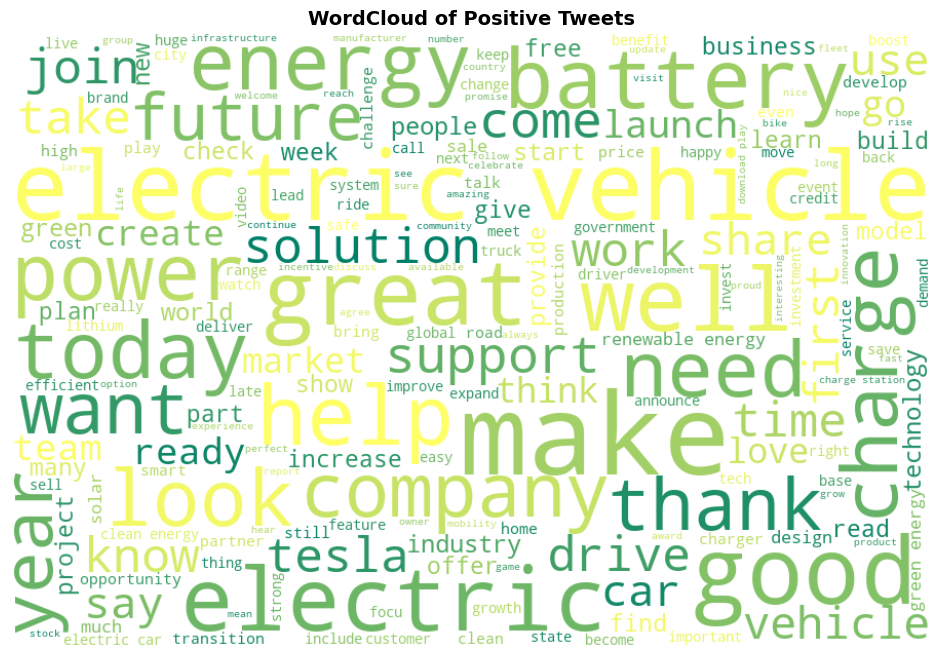

In [41]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='white', 
                      max_words=200,colormap='summer').generate(all_words_pos)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Positive Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

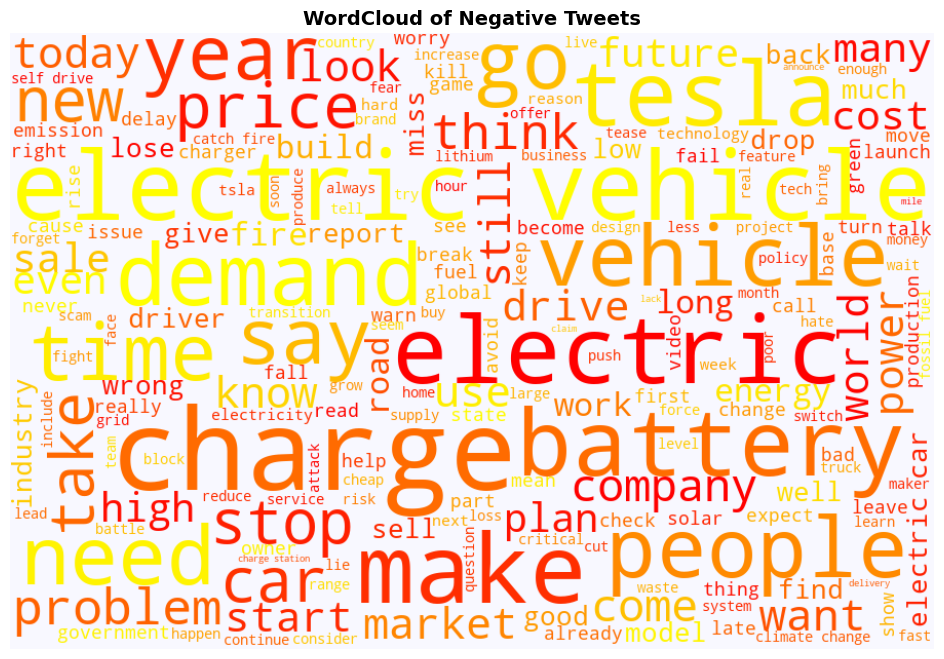

In [42]:
wordcloud = WordCloud(width=900, height=600, random_state=21, max_font_size=110, background_color='ghostwhite', 
                      max_words=200,colormap='autumn').generate(all_words_neg)

plt.figure(figsize=(12, 8))
plt.title('WordCloud of Negative Tweets', fontsize=14, fontweight="bold")
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis('off')
plt.show()

### Compound Score Distribution 

C:\Users\Dodlaraj\AppData\Local\Temp\ipykernel_22304\667362866.py:7: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x1, color="g", bins=15, hist_kws={"alpha": 0.5,"rwidth":0.8})
C:\Users\Dodlaraj\AppData\Local\Temp\ipykernel_22304\667362866.py:14: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(x2,

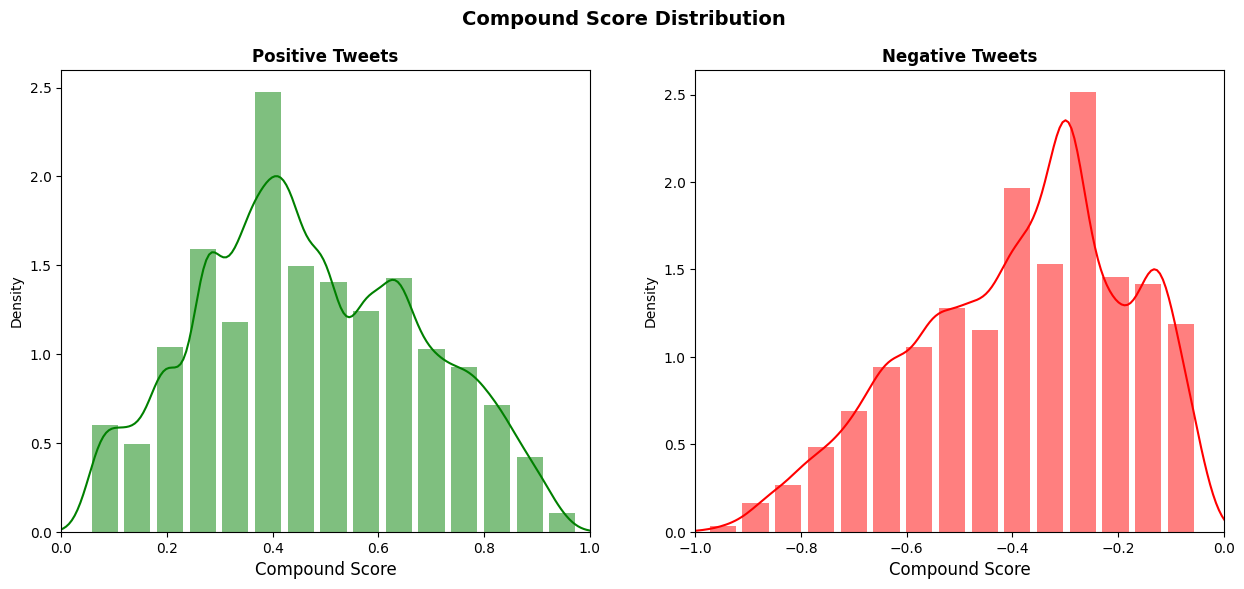

In [43]:
x1 = df_pos['compound']
x2 = df_neg['compound']
plt.figure(figsize=(15,6))
plt.suptitle('Compound Score Distribution', fontsize=14, fontweight="bold")
plt.subplot(1,2,1)

sns.distplot(x1, color="g", bins=15, hist_kws={"alpha": 0.5,"rwidth":0.8})
plt.title('Positive Tweets',fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([0,1])

# Chart 2: Derivative Function
plt.subplot(1,2,2)
sns.distplot(x2, color="r", bins=15, hist_kws={"alpha": 0.5, "rwidth":0.8})
plt.title("Negative Tweets",fontsize=12, fontweight="bold")
plt.xlabel("Compound Score", fontsize=12)
plt.xlim([-1,0])

plt.show()

In [44]:
x1.describe()

count    41127.000000
mean         0.472459
std          0.207823
min          0.051100
25%          0.318200
50%          0.447200
75%          0.636000
max          0.979200
Name: compound, dtype: float64

In [45]:
x2.describe()

count    12203.000000
mean        -0.384682
std          0.199455
min         -0.979000
25%         -0.526700
50%         -0.359500
75%         -0.226300
max         -0.050000
Name: compound, dtype: float64

### Box Plot

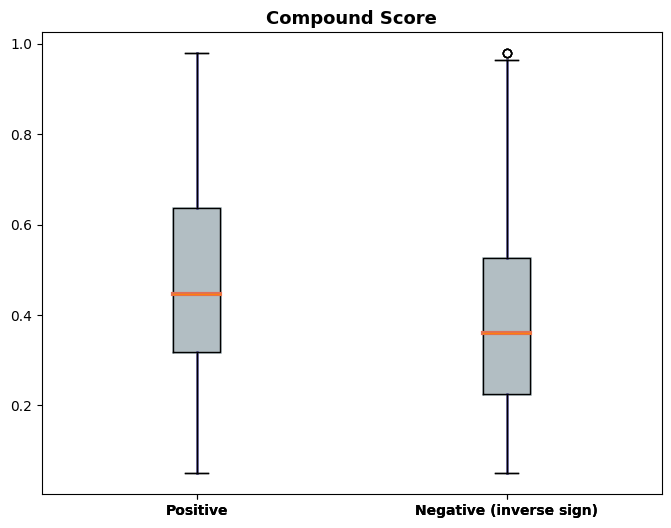

In [46]:
data_to_plot = [x1,(x2)*-1]
# Box-plot
fig = plt.figure(1, figsize=(8, 6))
ax = fig.add_subplot(111)
bp = ax.boxplot(data_to_plot, patch_artist=True)
for box in bp['boxes']:
    # change outline color
    box.set( color='#b2bec3', linewidth=2)
## change color and linewidth of the whiskers
for whisker in bp['whiskers']:
    whisker.set(color='#7570b3', linewidth=2)
for median in bp['medians']:
    median.set(color='#e17055', linewidth=3)
plt.boxplot(data_to_plot)
plt.title('Compound Score', fontsize=13, fontweight='bold')
ax.set_xticklabels(['', '', 'Positive', 'Negative (inverse sign)'], fontweight='bold')
plt.show()

### 10 Most Positive and Negative Tweets

In [47]:
# 10 Most positive Tweets
df_pos.sort_values('compound', inplace=True, ascending=False)
df_pos.reset_index(drop=True, inplace=True)

C:\Users\Dodlaraj\AppData\Local\Temp\ipykernel_22304\2308027815.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_pos.sort_values('compound', inplace=True, ascending=False)


In [48]:
df_pos.head(10)

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,word_count,character_count,emoji_percent,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Mon Oct 31 15:32:00 +0000 2022,1587105111700119559,1587105111700119559,RT @investanley: Why is always good time to ad...,False,"{'hashtags': [{'text': 'SONY', 'indices': [59,...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,23,140,0.000000,RT : Why is always good time to add more $SONY...,0.0,0.418,0.582,0.9792,1,"[always, good, time, good, quality, content, g..."
1,Sun Oct 23 17:47:52 +0000 2022,1584240203547320320,1584240203547320320,Best wishes on the joyous occasion of Diwali a...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,22,139,0.000000,Best wishes on the joyous occasion of Diwali a...,0.0,0.395,0.605,0.9698,1,"[good, wish, joyous, occasion, fill, love, hap..."
2,Sat Nov 19 17:06:17 +0000 2022,1594014209703964673,1594014209703964673,A VERY special congrats and HAPPY BIRTHDAY🎂to ...,True,"{'hashtags': [{'text': 'awesome', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,18,140,0.714286,A VERY special congrats and HAPPY BIRTHDAY🎂to ...,0.0,0.332,0.668,0.9687,1,"[special, congrat, happy, birthday, client, ex..."
3,Sat Nov 19 05:28:15 +0000 2022,1593838544438558720,1593838544438558720,AMAZING Beach Fishing w/ Electric Bike! BEST F...,True,"{'hashtags': [{'text': 'AMAZING', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://publicize.wp.com/"" rel=""nofoll...",NaN,NaN,...,19,136,0.000000,AMAZING Beach Fishing w/ Electric Bike! BEST F...,0.0,0.390,0.610,0.9674,1,"[amazing, beach, fishing, electric, good, beac..."
4,Tue Oct 18 17:11:51 +0000 2022,1582419199560806413,1582419199560806413,Why is always good time to add more $SONY #SON...,True,"{'hashtags': [{'text': 'SONY', 'indices': [42,...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,21,139,0.000000,Why is always good time to add more $SONY SONY...,0.0,0.464,0.536,0.9661,1,"[always, good, time, good, quality, content, g..."
5,Wed Oct 26 02:30:01 +0000 2022,1585096378933542913,1585096378933542913,"celebrate the Fun, love, and Caring with your ...",True,"{'hashtags': [{'text': 'bhaidooj', 'indices': ...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",NaN,NaN,...,19,136,0.735294,"celebrate the Fun, love, and Caring with your ...",0.0,0.373,0.627,0.9648,1,"[celebrate, love, care, sibling, create, last,..."
6,Mon Oct 24 04:12:13 +0000 2022,1584397323269853185,1584397323269853185,RT @joy_ebike: Let's celebrate the festival in...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,25,140,0.000000,RT : Let's celebrate the festival in the true ...,0.0,0.458,0.542,0.9643,1,"[true, sense, spread, lighting, world, other, ..."
7,Mon Oct 24 17:52:02 +0000 2022,1584603638516707328,1584603638516707328,RT @UnicusMobility: Let's celebrate the festiv...,False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/android"" ...",NaN,NaN,...,25,140,0.000000,RT : Let's celebrate the festival in the true ...,0.0,0.458,0.542,0.9643,1,"[true, sense, spread, light, world, other, hap..."
8,Mon Oct 24 04:40:00 +0000 2022,1584404315258732546,1584404315258732546,Be blessed with good luck and success and not ...,True,"{'hashtags': [{'text': 'GoGreen', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a hre

In [49]:
# 10 Most Negative Tweets
df_neg.sort_values('compound', inplace=True)
df_neg.reset_index(drop=True).head(15)

C:\Users\Dodlaraj\AppData\Local\Temp\ipykernel_22304\1157219457.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_neg.sort_values('compound', inplace=True)


,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,word_count,character_count,emoji_percent,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Sat Oct 08 17:12:49 +0000 2022,1578795562333196288,1578795562333196288,RT @FlyingFree333: Worst #nuclearpower disaste...,False,"{'hashtags': [{'text': 'nuclearpower', 'indice...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://youtube.com"" rel=""nofollow"">Vi...",NaN,NaN,...,21,140,0.0,RT : Worst nuclearpower disaster in history ki...,0.637,0.363,0.0,-0.9790,-1,"[bad, disaster, history, kill, less, people, b..."
1,Sat Oct 08 17:08:03 +0000 2022,1578794364784246785,1578794364784246785,Worst #nuclearpower disaster in history killed...,True,"{'hashtags': [{'text': 'nuclearpower', 'indice...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,19,140,0.0,Worst nuclearpower disaster in history killed ...,0.672,0.328,0.0,-0.9790,-1,"[bad, disaster, history, kill, less, people, b..."
2,Fri Oct 28 23:14:12 +0000 2022,1586134265720635392,1586134265720635392,"@1NewsNZ How many are injured, killed, poisone...",True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://mobile.twitter.com"" rel=""nofo...",1.586053e+18,1.586053e+18,...,19,144,0.0,"How many are injured, killed, poisoned, ensla...",0.649,0.351,0.0,-0.9652,-1,"[many, injure, kill, poison, enslave, bear, de..."
3,Fri Oct 28 23:41:52 +0000 2022,1586141227631648769,1586141227631648769,"RT @spacefish2: @1NewsNZ How many are injured,...",False,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://script.google.com/macros/s/AK...",NaN,NaN,...,22,144,0.0,"RT : How many are injured, killed, poisoned, ...",0.592,0.408,0.0,-0.9652,-1,"[many, injure, kill, poison, enslave, bear, de..."
4,Fri Nov 04 07:47:03 +0000 2022,1588437654701768704,1588437654701768704,Devastating Mistakes To Avoid After a Truck Ac...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://dlvrit.com/"" rel=""nofollow"">d...",NaN,NaN,...,21,140,0.0,Devastating Mistakes To Avoid After a Truck Ac...,0.644,0.356,0.0,-0.9578,-1,"[devastating, mistake, avoid, truck, accident,..."
5,Mon Oct 24 14:12:23 +0000 2022,1584548362317168644,1584548362317168644,RT @diar_esthetic: #climate #SCAM\nThere are m...,False,"{'hashtags': [{'text': 'climate', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://youtube.com"" rel=""nofollow"">Vi...",NaN,NaN,...,24,140,0.0,RT : climate SCAM\nThere are many dangers in t...,0.478,0.522,0.0,-0.9478,-1,"[many, danger, world, main, lie, hypocritical,..."
6,Mon Oct 24 13:58:51 +0000 2022,1584544955737210880,1584544955737210880,#climate #SCAM\nThere are many dangers in the ...,True,"{'hashtags': [{'text': 'climate', 'indices': [...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",NaN,NaN,...,22,140,0.0,climate SCAM\nThere are many dangers in the wo...,0.508,0.492,0.0,-0.9478,-1,"[many, danger, world, main, lie, hypocritical,..."
7,Mon Dec 05 13:24:25 +0000 2022,1599756580379328512,1599756580379328512,@CMShehbaz Stop oil to cut the OG import bill ...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://twitter.com/download/iphone"" r...",1.599745e+18,1.599745e+18,...,22,144,0.0,Stop oil to cut the OG import bill .\nThere i...,0.552,0.448,0.0,-0.9432,-1,"[stop, import, bill, death, destruction, clima..."
8,Wed Oct 19 21:35:41 +0000 2022,1582847982432448514,1582847982432448514,bUt wHaT AbOUT aLL tHe #ElectricVehicles DeAD ...,True,"{'hashtags': [{'text': 'ElectricVehicles', 'in...","{'iso_language_code': 'en', 'result_type':

### Trying and Testing on specific Tweets

In [50]:
df.head(5)

,created_at,id,id_str,text,truncated,entities,metadata,source,in_reply_to_status_id,in_reply_to_status_id_str,...,word_count,character_count,emoji_percent,tweet_text_p,negative,neutral,positive,compound,sentiment,lemmatized
0,Mon Dec 05 14:14:43 +0000 2022,1599769240004972544,1599769240004972544,RT @iot_automotive: 24h round-up. A collection...,False,"{'hashtags': [{'text': 'AI', 'indices': [95, 9...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://about.twitter.com/products/tw...",NaN,NaN,...,15,140,0.0,RT : 24h round-up. A collection of TOP TWEETS....,0.0,0.624,0.376,0.7206,1,"[collection, tweet, enjoy]"
1,Mon Dec 05 14:00:55 +0000 2022,1599765764113940483,1599765764113940483,Meet Powderworld: A Lightweight Simulation Env...,True,"{'hashtags': [], 'symbols': [], 'user_mentions...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""https://buffer.com"" rel=""nofollow"">Bu...",NaN,NaN,...,12,140,0.0,Meet Powderworld: A Lightweight Simulation Env...,0.0,1.000,0.000,0.0000,0,"[meet, simulation, environment, understand, ge..."
2,Mon Dec 05 14:00:04 +0000 2022,1599765552154775557,1599765552154775557,RT @GothamVirtual: #vr #vrgotham #3dvideomotio...,False,"{'hashtags': [{'text': 'vr', 'indices': [19, 2...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,18,140,0.0,RT : vr vrgotham 3dvideomotion This research p...,0.0,0.847,0.153,0.4404,1,"[research, paper, investigate, fix, roadside, ..."
3,Mon Dec 05 14:00:04 +0000 2022,1599765551378845697,1599765551378845697,RT @lidarnews: This research paper investigate...,False,"{'hashtags': [{'text': 'lidar', 'indices': [74...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,17,140,0.0,RT : This research paper investigates the use ...,0.0,0.828,0.172,0.4404,1,"[research, paper, investigate, fix, roadside, ..."
4,Mon Dec 05 14:00:04 +0000 2022,1599765550544130048,1599765550544130048,RT @guidaautonoma: American drivers are more l...,False,"{'hashtags': [{'text': 'autonomous', 'indices'...","{'iso_language_code': 'en', 'result_type': 're...","<a href=""http://robotconsumer.com/"" rel=""nofol...",NaN,NaN,...,22,140,0.0,RT : American drivers are more likely to a see...,0.0,0.850,0.150,0.4588,1,"[american, driver, likely, benefit, self, driv..."


In [51]:
df.columns

Index(['created_at', 'id', 'id_str', 'text', 'truncated', 'entities',
       'metadata', 'source', 'in_reply_to_status_id',
       'in_reply_to_status_id_str', 'in_reply_to_user_id',
       'in_reply_to_user_id_str', 'in_reply_to_screen_name', 'user', 'geo',
       'coordinates', 'place', 'contributors', 'retweeted_status',
       'is_quote_status', 'retweet_count', 'favorite_count', 'favorited',
       'retweeted', 'possibly_sensitive', 'lang', 'quoted_status_id',
       'quoted_status_id_str', 'quoted_status', 'extended_entities',
       'withheld_scope', 'withheld_in_countries', 'device', 'text_tokenized',
       'emoji_count', 'word_count', 'character_count', 'emoji_percent',
       'tweet_text_p', 'negative', 'neutral', 'positive', 'compound',
       'sentiment', 'lemmatized'],
      dtype='object')

In [52]:
df.to_csv('Vader.csv')

In [53]:
df['text'][5]

'RT @sallyeaves: Fact from Fiction! #MEC  \nLow-latency #impact on #AR #VR #haptics for:\n✅#gaming \n✅#automation \n✅#AutonomousVehicles \n@TheFa…'

In [54]:
tweet = df['text'][11]

In [55]:
sentiment_dict = vader_analyzer.polarity_scores(tweet) 
      
print("Overall sentiment is : ", sentiment_dict) 
print("sentence was rated as ", sentiment_dict['neg']*100, "% Negative") 
print("sentence was rated as ", sentiment_dict['neu']*100, "% Neutral") 
print("sentence was rated as ", sentiment_dict['pos']*100, "% Positive") 
  
print("Sentence Overall Rated As", end = " ")
# decide sentiment as positive, negative and neutral 
if sentiment_dict['compound'] >= 0.05 : 
    print("Positive") 
elif sentiment_dict['compound'] <= - 0.05 : 
    print("Negative")  
else : 
    print("Neutral")

Overall sentiment is :  {'neg': 0.0, 'neu': 1.0, 'pos': 0.0, 'compound': 0.0}
sentence was rated as  0.0 % Negative
sentence was rated as  100.0 % Neutral
sentence was rated as  0.0 % Positive
Sentence Overall Rated As Neutral


#### Normalization used by VADER
#### $latex \large \dfrac{x}{\sqrt{x^2 + \alpha}}$

### Save Results as a Dataframe

In [56]:
df.drop(['tweet_text_p', 'lemmatized'], axis=1, inplace=True)

In [57]:
df.to_pickle('./sentiment_analysis_vader_results.pkl')